<a href="https://colab.research.google.com/github/SteffanBurnette/TensorFlow-/blob/Xray_lung_classification/Pneumonia_classification_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Chest X-Ray Disease Classification
The dataset that I will be using to train the neural network is a **prelabeled PNEUMONIA** dataset. The goal of this project is to create a **convolutional neural network** that will be able to take X-rays of a patients chest as input and identify if that individual has pneumonia or not.

In [3]:
!pip install -q opendatasets

In [4]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images") # insert ypu kaggle  username and key
#pddf = pd.read_csv('/content/dish-network-hackathon/Test_Dataset.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: frentr
Your Kaggle Key: ··········


100%|██████████| 1.17G/1.17G [00:58<00:00, 21.4MB/s]


###Setting up the project environment
Here, I am imported the required dependancies that will allow me to complete this task. I plan on importing a pretrain model that is used for image classification and performing transfer learning via tensorflow hub.

In [ ]:
!pip install opencv-python

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt #Used to visualize data and findings
from tensorflow.keras.models import Sequential #Will use a layer to layer architecture
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D  #Will maybe utilize the Conv2D and MaxPool layers depending on the initial findings
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy #Will use binary as the loss function
from tensorflow.keras.optimizers import Adam, SGD #Used to reduce the loss while simultaniously increasing the models accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Used to load in in preprocess the image data
import tensorflow_hub as hub #Used to load in the model from tensorflow hub

##Functionizing The Analysis of Model Performance
* Create a function to create **confusion matrices** and **plot confusion matrices**
* Create a function to evaluate the model, make predictions, and get the **accuracy, precision, recall, f1score** (maybe the **specificity** aswell)
* Create a function to perform **Cross Validation** (most likely **Leave-One-Out Cross Validation**)

I might combine points 2 & 3 into a single function if possible.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

def deep_analysis(model, dataset):
  """
  This function will take in a model, the training set to make prediction's on and
  the true values that the model is trying to predict.
  It will caculate and return the accuracy, precision, recall and f1Score metrics of the model's
  predictions in n object to gain further insight into the model's performance.
  The function will also create a confusion matrix and plot it for the user.
  """
  #Gets the dataset labels
  labels = dataset.classes
  #Gets the model's predictions, rounds to the nearest prediction
  predictions = tf.round(model.predict(dataset))

  #Calculate model accuracy
  model_accuracy = accuracy_score(labels, predictions) * 100

  #Calculate models precision, recall, f1score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(labels, predictions, average = "weighted")

  print(f"Accuracy: {'{:.2f}'.format(model_accuracy)}% \n Precision: {'{:.2f}'.format(model_precision * 100)}% \n Recall: {'{:.2f}'.format(model_recall * 100)}% \n F1-Score: {'{:.2f}'.format(model_f1 * 100)}% \n")

  #Create the confusion matrix
  con_matrix = confusion_matrix(labels, predictions)
  #Create's the confusion matrix display object to plot the matrix with
  display = ConfusionMatrixDisplay(confusion_matrix=con_matrix)
  #Plots the confusion matrix so that the user can get a visual representation of it
  display.plot()
  plt.show()

  #Store's all of the metrics and matrix in a dictionary
  model_results = {
      "Accuracy":model_accuracy,
      "Precision":model_precision * 100,
      "Recall":model_recall * 100,
      "F1-Score":model_f1 * 100,
      "Confusion_matrix":con_matrix,
      "Confusion_matrix_display":display
  }

  return model_results




###Visualize the data
Great, now lets first set up the directories and visualize the data that we will be working with.

In [9]:
train_dir = "/content/labeled-chest-xray-images/chest_xray/train"
train_dir_normal = "/content/labeled-chest-xray-images/chest_xray/train/NORMAL"
train_dir_pneumonia = "/content/labeled-chest-xray-images/chest_xray/train/PNEUMONIA"
test_dir = "/content/labeled-chest-xray-images/chest_xray/test"
test_dir_normal = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL"
test_dir_pneumonia = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA"


print(f"The test directory has {len(test_dir_normal)} normal xrays and {len(test_dir_pneumonia)} pneumonia xrays")
print(f"The train directory has {len(train_dir_normal)} normal xrays and {len(train_dir_pneumonia)} pneumonia xrays")
print("Roughly the same amount of examples in each directory")
len(train_dir), len(test_dir)

The test directory has 57 normal xrays and 60 pneumonia xrays
The train directory has 58 normal xrays and 61 pneumonia xrays
Roughly the same amount of examples in each directory


(51, 50)

###Findings
The test and training directory has roughly a 80-20 split. Since I will be leveraging the **efficientnet model** this is looking to be promising since the data is properly labeled and split in an ideal manner. If however I find that the model is **underfitting/Overfitting** during training I will move/augment some of the data to the train dataset.

In [10]:
#Setting up the inital params
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

#When loading in the images, it will normalize the data to fit the model better
train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)

print("Training images data: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size = IMAGE_SHAPE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = "binary")

print("Test data images data: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size= IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode = "binary")


Training images data: 
Found 5232 images belonging to 2 classes.
Test data images data: 
Found 624 images belonging to 2 classes.


###Loading the Efficientnet model from Tensorflow hub
Now I will load the model from tensorflow hub as a **kerasLayer**

In [9]:
#The url that i will be loading the model from
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

 #Downloads the pretrained model and save it as a keras layer
feature_extraction_layer = hub.KerasLayer(efficientnet_url,
                                             trainable = False,#Freezes the patterns that the pretrained model has learned
                                             name = "Feature_Extraction_Layer",
                                             input_shape = IMAGE_SHAPE+(3,)) #Turns shape into (224, 224, 3)
    #We will be able to put the entire model as a layer into the model that we create

    #Create our own model
model = Sequential([
        feature_extraction_layer, #Efficienet model will handle the inputs
        Dense(1, activation="sigmoid", name = "output_layer") #Only two categories: normal, pneumonia
    ])

In [10]:
train_data[0]

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.01568628, 0.01568628, 0.01568628],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.02745098, 0.02745098, 0.02745098],
          [0.01568628, 0.01568628, 0.01568628],
          [0.01568628, 0.01568628, 0.01568628]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.06666667, 0.06666667, 0.06666667],
          [0.0627451 , 0.0627451 , 0.0627451 ],
          [0.02745098, 0.02745098, 0.02745098]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

###Compiling and Fitting the model
Will now compile the model and fit it to the training data while evaluating it's performance with the test data

In [11]:
#Setting up the loss function, optimizer and metric that the models performance will be evaluated on
model.compile(loss = BinaryCrossentropy(),
              optimizer = Adam(),
              metrics = ["accuracy"])

#Will train and evaluate the model, while keep track of its training/evaluation history so that I can view the loss curves
history = model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data),
          validation_data = test_data, validation_steps = len(test_data))

Epoch 1/5
164/164 [==============================] - 60s 305ms/step - loss: 0.2767 - accuracy: 0.8928 - val_loss: 0.3893 - val_accuracy: 0.7885
Epoch 2/5
164/164 [==============================] - 48s 290ms/step - loss: 0.1541 - accuracy: 0.9494 - val_loss: 0.3042 - val_accuracy: 0.8606
Epoch 3/5
164/164 [==============================] - 48s 291ms/step - loss: 0.1242 - accuracy: 0.9580 - val_loss: 0.3092 - val_accuracy: 0.8574
Epoch 4/5
164/164 [==============================] - 49s 296ms/step - loss: 0.1063 - accuracy: 0.9644 - val_loss: 0.2697 - val_accuracy: 0.8782
Epoch 5/5
164/164 [==============================] - 47s 288ms/step - loss: 0.0962 - accuracy: 0.9677 - val_loss: 0.2827 - val_accuracy: 0.8766


###Model after training
Would you look at that!!, the model performed with 98% accuracy on the training data and 88% accuracy on the test data(unseen data). This is very good and while there are things that can be done to increase the performance(finding the **ideal learning rate** or performing **fine tuning**) this is still a really good outcome. Now lets plot the **loss curves** and see a visual representation of our models performance.

In [30]:
#Lets create a function to plot our loss curves
#Note that this function will fail if we are using an evaluation metric that is not accuracy
#Plot the validation and training curves seperately
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) #How many epochs did we run for

  #Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs,val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

    #Plot Accuracy
  plt.figure() #Creates a new figure
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs,val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

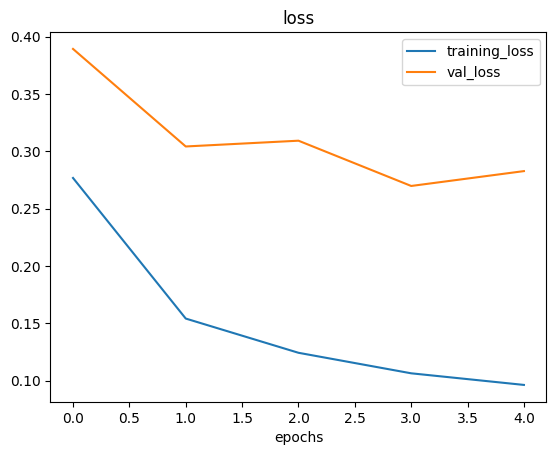

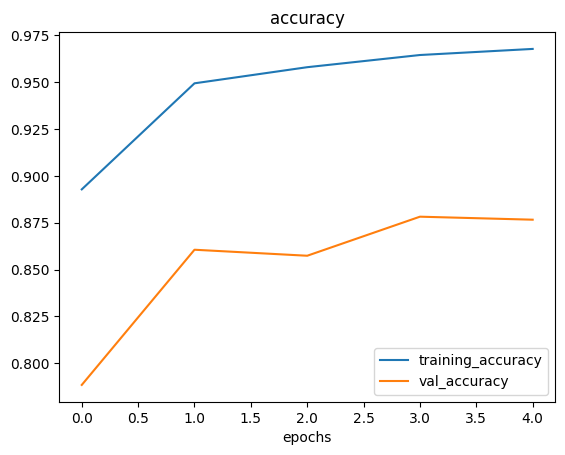

In [13]:
plot_loss_curves(history)

There seems to be some potential signs of overfitting, but lets perform some prediction and see if our model performs well.

In [14]:
#Get sample data batches
images, labels = train_data.next()


Showing random image number: 19


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, *, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

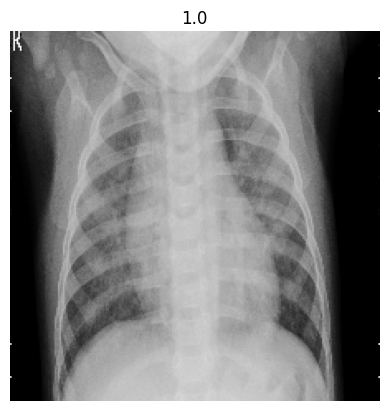

In [15]:
#Show the original image and the augmented image
random_number =random.randint(0, 31) #Our batch sizes are 32 so the random integer will be choosen from 0-31
print(f"Showing random image number: {random_number}")
plt.imshow(images[random_number])
plt.title(labels[random_number])
plt.axis(False);
plt.figure


In [ ]:
model.predict(test_data)

20/20 [==============================] - 7s 294ms/step


array([[1.81734692e-02],
       [3.79463797e-03],
       [6.03904247e-01],
       [9.92503405e-01],
       [9.99991059e-01],
       [9.99986529e-01],
       [9.97745574e-01],
       [1.55041507e-02],
       [9.99931335e-01],
       [9.99888182e-01],
       [9.99985218e-01],
       [9.89325404e-01],
       [9.99901056e-01],
       [9.99985933e-01],
       [9.99963284e-01],
       [7.06679821e-02],
       [9.98795033e-01],
       [3.54583353e-01],
       [5.06822824e-01],
       [9.99808371e-01],
       [8.57254207e-01],
       [9.99526024e-01],
       [9.99816120e-01],
       [9.75449800e-01],
       [6.62235692e-02],
       [9.99974728e-01],
       [9.99966383e-01],
       [9.99955177e-01],
       [2.48835189e-03],
       [9.99313593e-01],
       [6.84911236e-02],
       [9.99959707e-01],
       [9.99657273e-01],
       [9.99906301e-01],
       [9.99602139e-01],
       [3.55960280e-02],
       [9.99967575e-01],
       [9.99959707e-01],
       [9.96919274e-01],
       [9.99960661e-01],


In [17]:
class_names = ["Normal", "Pneumonia"]

In [85]:
#Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_img(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, color_channels)
  """
  #Read in the image
  img = tf.io.read_file(filename)

  #Decode the read file into a tensor
  img = tf.image.decode_image(img)

  rgb_image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  img = rgb_image
  #Resize the image
  img = tf.image.resize(img, size = [img_shape, img_shape])
  #Rescale the image (get all values between 0 and 1)
  img=img/255.
  return img

In [86]:
#Experimental
def load_and_prep_img(filename, img_shape= 224):
    # Load in the image
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img)

    # Check if the image is grayscale (if so, convert to RGB)
    if img.shape[-1] == 1:
        # Convert the image to a NumPy array
        img_array = img.numpy()
        # Convert grayscale to RGB
        rgb_image = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        img = tf.convert_to_tensor(rgb_image)

    # Resize the image
    img = tf.image.resize(img, size = [img_shape, img_shape])
    # Rescale the image (if required)
    img = img/255. #(Only if your model expects pixel values in the range [0, 1])
    return img

In [88]:
class_names = ["Normal", "Pneumonia"]
def pred_and_plot(model, filename, class_names=class_names):
  """ Imports a image located at filename, makes a prediction with model and
  plots the image with the predicted class as the title
  """
  #Import the target image and preprocess it
  img = load_and_prep_img(filename)

  #Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  #Add in logic for predictions since a softmax function returns a nested list of multiple predictions
  #Unlike a sigmoid function which only returns the predicted value
  if len(pred)> 1: #Handles multiclass images logic
    pred_class = class_names[tf.argmax(pred[0])] #Gets the class name of the highest prediction value
  else:  #Handles binary class images logic
    #Get the predicted class
    pred_class = class_names[int(tf.round(pred[0]))]

  #Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 26ms/step


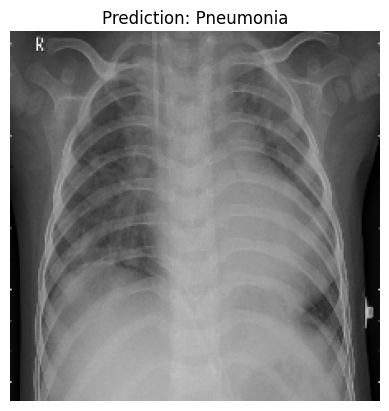

In [ ]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0003.jpeg", class_names = class_names)

1/1 [==============================] - 0s 36ms/step


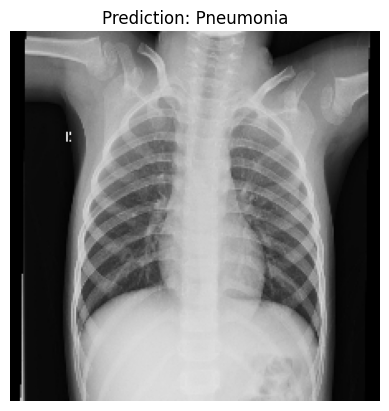

In [ ]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg", class_names = class_names)

1/1 [==============================] - 0s 24ms/step


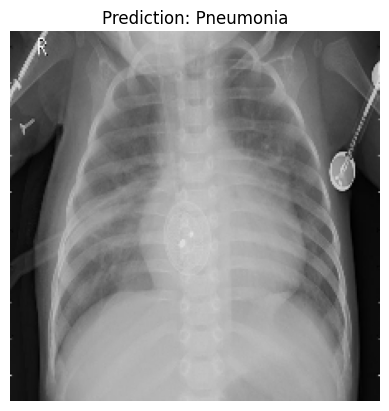

In [ ]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1768914-0003.jpeg", class_names = class_names)

1/1 [==============================] - 0s 25ms/step


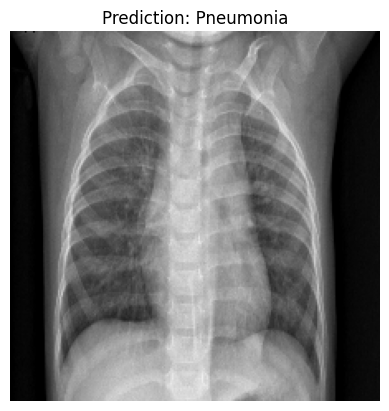

In [ ]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg", class_names = class_names)

1/1 [==============================] - 0s 66ms/step


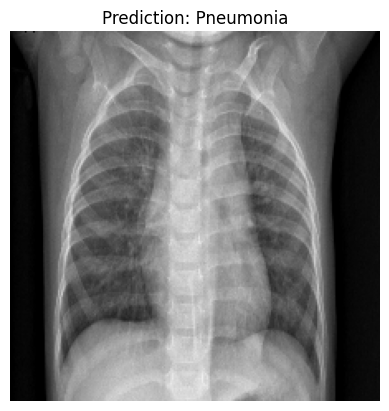

In [ ]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg", class_names = class_names)

1/1 [==============================] - 0s 41ms/step


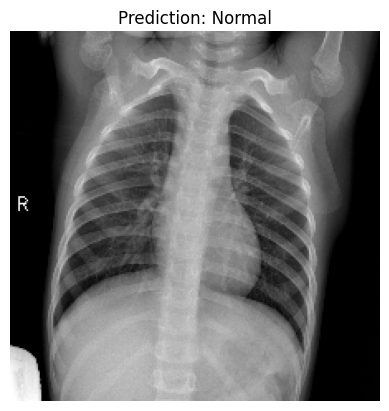

In [ ]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-3395085-0001.jpeg", class_names = class_names)

1/1 [==============================] - 0s 26ms/step


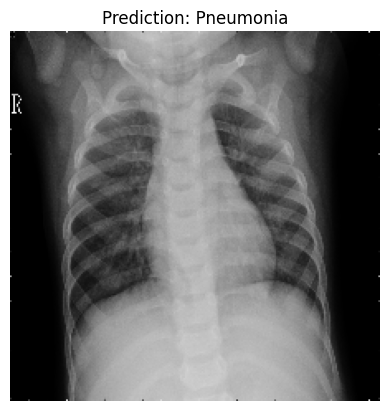

In [ ]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-4315572-0001.jpeg", class_names = class_names)

###Takeaways
* The model has a hard time distinguishing a normal X-Ray from a pneumonia x-ray, which is to be expected since the efficientnet was trained on rgb images. Its still able to properly distingust **pneumonia x-rays**.

*First I will train the model fro less epochs and see if theres an improvement in the loss curves(from analizing it 5 epochs should be enough)

I will create a model from scratch to see if it will perform better, but this current model is not bad and will be saved.

###Creating a Second Model


In [66]:
   #Create our own model
model_2 = Sequential([
        feature_extraction_layer, #Efficienet model will handle the inputs
        Dense(1, activation="sigmoid", name = "output_layer") #Only two categories: normal, pneumonia
    ])

In [67]:
#Setting up the loss function, optimizer and metric that the models performance will be evaluated on
model_2.compile(loss = BinaryCrossentropy(),
              optimizer = Adam(),
              metrics = ["accuracy"])

#Will train and evaluate the model, while keep track of its training/evaluation history so that I can view the loss curves
history_2 = model_2.fit(train_data, epochs = 5, steps_per_epoch = len(train_data),
          validation_data = test_data, validation_steps = len(test_data))

Epoch 1/5
164/164 [==============================] - 49s 288ms/step - loss: 0.3445 - accuracy: 0.8545 - val_loss: 0.3632 - val_accuracy: 0.8141
Epoch 2/5
164/164 [==============================] - 46s 280ms/step - loss: 0.1731 - accuracy: 0.9413 - val_loss: 0.3503 - val_accuracy: 0.8221
Epoch 3/5
164/164 [==============================] - 46s 278ms/step - loss: 0.1361 - accuracy: 0.9580 - val_loss: 0.3196 - val_accuracy: 0.8446
Epoch 4/5
164/164 [==============================] - 46s 280ms/step - loss: 0.1176 - accuracy: 0.9616 - val_loss: 0.2752 - val_accuracy: 0.8750
Epoch 5/5
164/164 [==============================] - 46s 277ms/step - loss: 0.1039 - accuracy: 0.9660 - val_loss: 0.2447 - val_accuracy: 0.8878


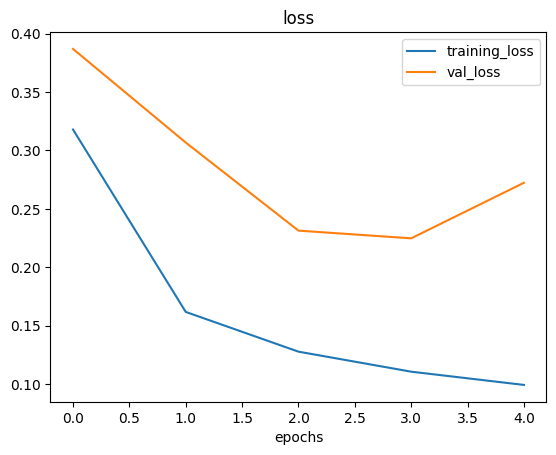

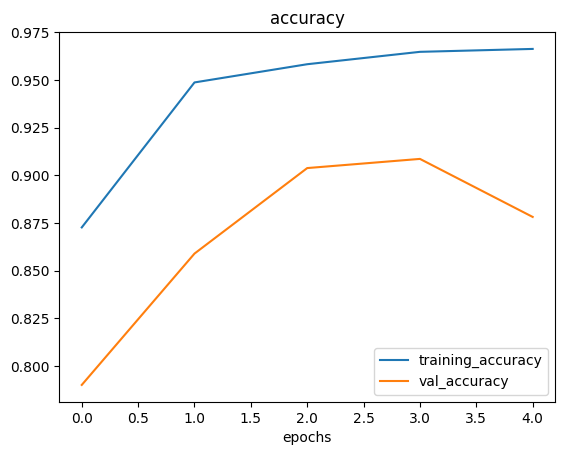

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model_3 = Sequential([
        feature_extraction_layer, #Efficienet model will handle the inputs
        Dense(1, activation="sigmoid", name = "output_layer") #Only two categories: normal, pneumonia
    ])

In [ ]:
#Setting up the loss function, optimizer and metric that the models performance will be evaluated on
model_3.compile(loss = BinaryCrossentropy(),
              optimizer = Adam(),
              metrics = ["accuracy"])

#Will train and evaluate the model, while keep track of its training/evaluation history so that I can view the loss curves
history_3 = model_3.fit(train_data, epochs = 4, steps_per_epoch = len(train_data),
          validation_data = test_data, validation_steps = len(test_data))

Epoch 1/4
164/164 [==============================] - 58s 338ms/step - loss: 0.2828 - accuracy: 0.8842 - val_loss: 0.3674 - val_accuracy: 0.8077
Epoch 2/4
164/164 [==============================] - 54s 328ms/step - loss: 0.1528 - accuracy: 0.9484 - val_loss: 0.3137 - val_accuracy: 0.8542
Epoch 3/4
164/164 [==============================] - 54s 326ms/step - loss: 0.1226 - accuracy: 0.9606 - val_loss: 0.2985 - val_accuracy: 0.8622
Epoch 4/4
164/164 [==============================] - 54s 328ms/step - loss: 0.1060 - accuracy: 0.9671 - val_loss: 0.2871 - val_accuracy: 0.8766


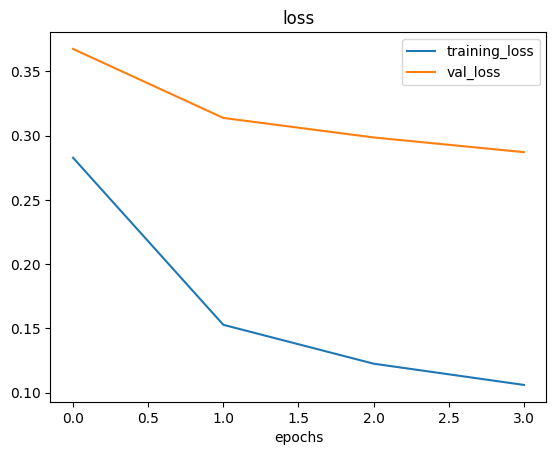

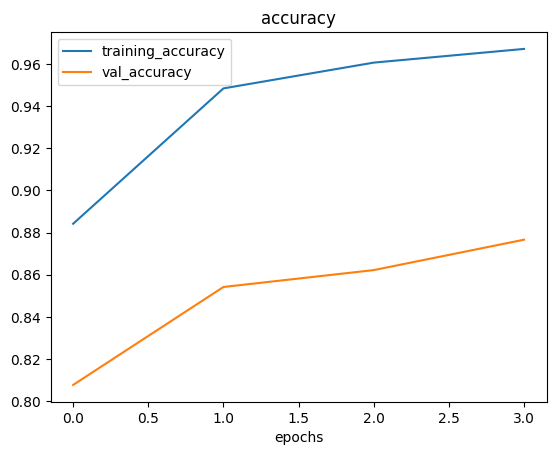

In [ ]:
plot_loss_curves(history_3)

By training the model for less epochs, ive successfully reduced the **overfitting** that was occuring at the end of the first model's training. Now i will use it to predict the image values given and rate its results.

1/1 [==============================] - 0s 27ms/step


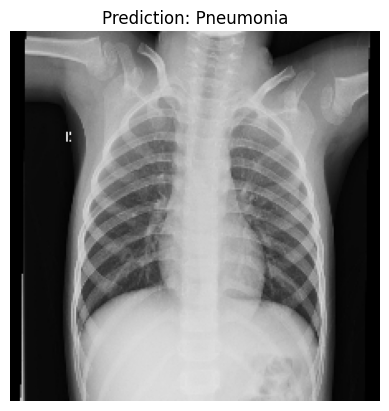

In [ ]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg", class_names = class_names)



1/1 [==============================] - 0s 37ms/step


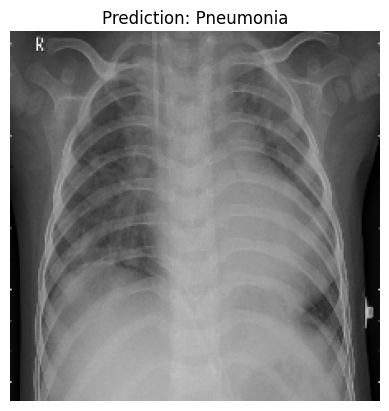

In [ ]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0003.jpeg", class_names = class_names)


1/1 [==============================] - 0s 54ms/step


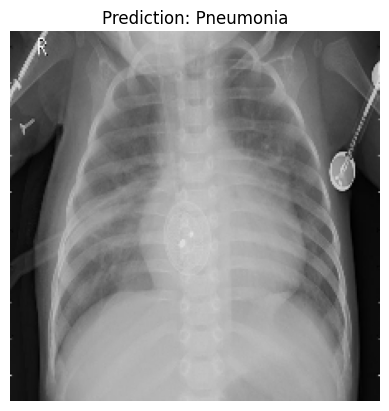

In [ ]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1768914-0003.jpeg", class_names = class_names)


1/1 [==============================] - 0s 27ms/step


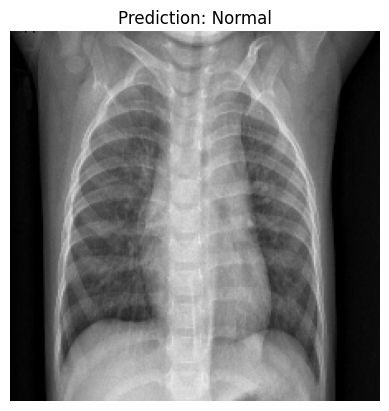

In [ ]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg", class_names = class_names)


1/1 [==============================] - 0s 26ms/step


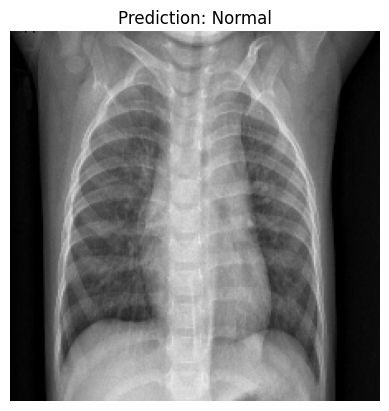

In [ ]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg", class_names = class_names)


1/1 [==============================] - 0s 26ms/step


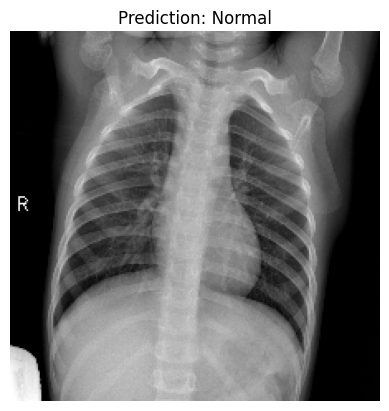

In [ ]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-3395085-0001.jpeg", class_names = class_names)


1/1 [==============================] - 0s 26ms/step


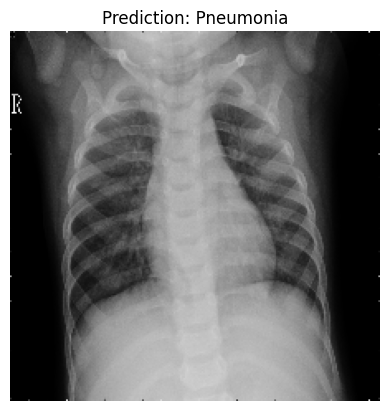

In [ ]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-4315572-0001.jpeg", class_names = class_names)

###Overall performance
While not correct on all predictions, `model_3` is out performing the first model c0onstructed and is indentifying the normal x-ray scans and pneumonia x ray scans more consistently. This is great news as it shows progress in the development of the neural network.

###Saving the neural network to be loaded in at a different time

In [ ]:
model_3.save("Normal_and_Pneumonia_xray_classification")

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Deep Learning Stuff/Normal_and_Pneumonia_xray_classification')

# Making the model without a backbone
I want to create the pnuemonia classification model without using the **efficientnet** model as a backbone and see if I can surpass it's performance.

#Preprocessing layer
I will create a model that handle's **data augmentation** and add it as a layer to other models so that they can experience more variations of data.This will be good since the **data augmentation** will be sped up by the **gpu/tpu** due to it being a layer while also adding more diversity to the dataset.

In [11]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Resizing
data_augmentation_layer = tf.keras.models.Sequential([
    Resizing(height = 224, width = 224), #This layer will reshape the image to this size, then perform preprocessing in the follow steps
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
   # preprocessing.RandomZoom(0.2), #Will comment this out to see if it effecting the output shape of this layer
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.Rescaling(scale = 1./255.) #Normalizes the pixel values of the image to be within the same range while keeping the distribution

], name = "Data_Augmentation_Layer")

# Loading In the Data
Because the model has data processing/augmentation built in, I will just load the images from the train and test directory without performing any alterations(like rescaling).

In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_data_unaug = image_dataset_from_directory(train_dir, image_size=(224,224), label_mode = "binary", batch_size = 32)
test_data_unaug = image_dataset_from_directory(test_dir, image_size = (224, 224), label_mode = "binary", batch_size = 32)

Found 5232 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [15]:
#This model should inherity handle data preprocessing/ data augmentation, along with finding the respective weights/patterns
#The speed of the augmentation/preprocessing will be sped up by the gpus since the process in imbedded within a layer
model_1a = tf.keras.models.Sequential([

    #data_augmentation_layer,
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = (3,3),
                           activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2,
                              padding="valid"), #Finds the important parts of the features gathered by the conv layer and discards the rest (Dimensionality Reduction)
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = 2, padding = "valid"), #Adds padding to the border to inspect the corner values efficiently
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer") #Returns either 0 or 1 for the predictions


])

In [16]:
model_1a.compile(loss = BinaryCrossentropy(),
                 optimizer = Adam(),
                 metrics = ["accuracy"])

In [17]:
history_1a = model_1a.fit(train_data, epochs = 5, steps_per_epoch = len(train_data),
                          validation_data = test_data, validation_steps = len(test_data))

Epoch 1/5
164/164 [==============================] - 51s 287ms/step - loss: 0.2561 - accuracy: 0.8912 - val_loss: 0.3155 - val_accuracy: 0.8734
Epoch 2/5
164/164 [==============================] - 49s 298ms/step - loss: 0.1084 - accuracy: 0.9593 - val_loss: 0.4208 - val_accuracy: 0.8574
Epoch 3/5
164/164 [==============================] - 47s 289ms/step - loss: 0.0781 - accuracy: 0.9696 - val_loss: 0.4956 - val_accuracy: 0.8494
Epoch 4/5
164/164 [==============================] - 48s 290ms/step - loss: 0.0691 - accuracy: 0.9753 - val_loss: 0.5046 - val_accuracy: 0.8542
Epoch 5/5
164/164 [==============================] - 49s 297ms/step - loss: 0.0509 - accuracy: 0.9805 - val_loss: 0.6055 - val_accuracy: 0.8429


The model achieved an accurcy of 84%, but I can see that with some fine tuning of the hyperparameters it can do better. This is beacuse I noticed during the training process that the model actually peaked at 87%. This means that at the end, the model started to **overfit** a little bit causing the slight decline in performance. I will implement a **Earlystopping** callback to avoid this issue along with a **LearnerRateScheduler** callback to perform exponential decay on the learning rate after the 2ndish epoch.

In [33]:
#Create an instance of the early stopping callbadk
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Metric to be monitored will be validation accuracy since it shows us how well our model is generalizing
    patience=2,             # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,        # Minimum change in the monitored quantity to qualify as an improvement
    mode='min',             # In 'min' mode, training will stop when the quantity monitored has stopped decreasing
    verbose=1
)

#Exponetial Decay
def scheduler(epoch, lr):
  if epoch <= 2:
    return lr #Uses the same set learning rate for the first 3 epochs
  else:
    return lr * tf.math.exp(-0.1) #Exponetially decays the learning rate


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

Rounding all of the models predictions to get the proper **binary** values. Now I can compare it with the labels from the test dataset

In [21]:
preds = tf.round(model_1a.predict(test_data))
preds

20/20 [==============================] - 5s 254ms/step


<tf.Tensor: shape=(624, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
 

# Test dataset labels
I will load in the dataset unshuffled so that the predictions can match the labels.

In [24]:
print("Test data images data: ")
test_data_unshuffle = test_datagen.flow_from_directory(test_dir,
                                             target_size= IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode = "binary",
                                                       shuffle = False)

Test data images data: 
Found 624 images belonging to 2 classes.


In [25]:
test_data_labels = test_data_unshuffle.classes
test_data_labels


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [26]:
preds = tf.round(model_1a.predict(test_data_unshuffle))
preds

20/20 [==============================] - 5s 248ms/step


<tf.Tensor: shape=(624, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
 

From looking at the loss curves its seems as if the model is **overfitting**. Will need to look into more metrics to confirm.

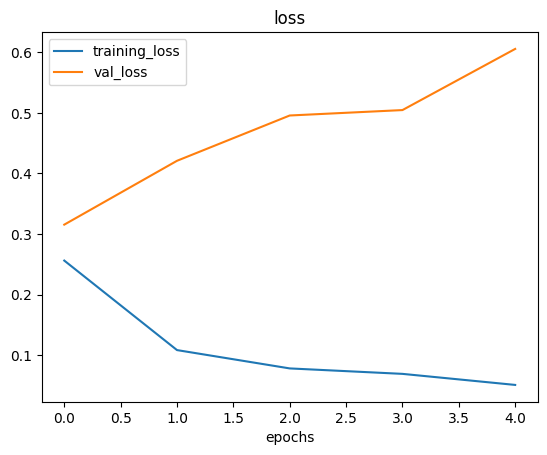

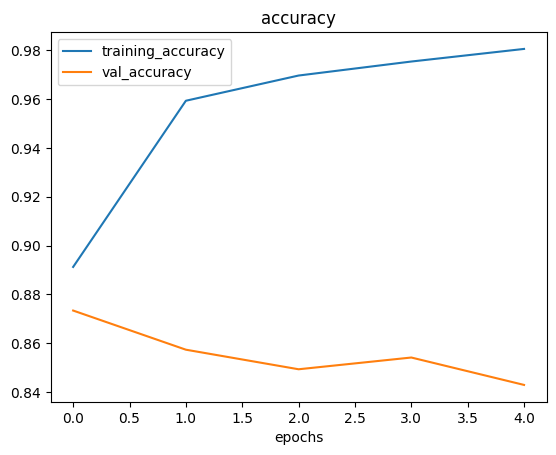

In [31]:
plot_loss_curves(history_1a)

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

def deep_analysis(model, dataset):
  """
  This function will take in a model, the training set to make prediction's on and
  the true values that the model is trying to predict.
  It will caculate and return the accuracy, precision, recall and f1Score metrics of the model's
  predictions in n object to gain further insight into the model's performance.
  The function will also create a confusion matrix and plot it for the user.
  """
  #Gets the dataset labels
  labels = dataset.classes
  #Gets the model's predictions, rounds to the nearest prediction
  predictions = tf.round(model.predict(dataset))

  #Calculate model accuracy
  model_accuracy = accuracy_score(labels, predictions) * 100

  #Calculate models precision, recall, f1score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(labels, predictions, average = "weighted")

  print(f"Accuracy: {'{:.2f}'.format(model_accuracy)}% \n Precision: {'{:.2f}'.format(model_precision * 100)}% \n Recall: {'{:.2f}'.format(model_recall * 100)}% \n F1-Score: {'{:.2f}'.format(model_f1 * 100)}% \n")

  #Create the confusion matrix
  con_matrix = confusion_matrix(labels, predictions)
  #Create's the confusion matrix display object to plot the matrix with
  display = ConfusionMatrixDisplay(confusion_matrix=con_matrix)
  #Plots the confusion matrix so that the user can get a visual representation of it
  display.plot()
  plt.show()

  #Store's all of the metrics and matrix in a dictionary
  model_results = {
      "Accuracy":model_accuracy,
      "Precision":model_precision * 100,
      "Recall":model_recall * 100,
      "F1-Score":model_f1 * 100,
      "Confusion_matrix":con_matrix,
      "Confusion_matrix_display":display
  }

  return model_results




20/20 [==============================] - 5s 261ms/step
Accuracy: 84.29% 
 Precision: 87.25% 
 Recall: 84.29% 
 F1-Score: 83.13% 



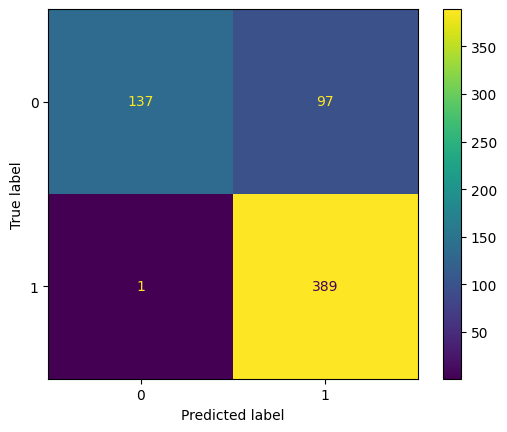

{'Accuracy': 84.2948717948718,
 'Precision': 87.25398103417427,
 'Recall': 84.2948717948718,
 'F1-Score': 83.1289586095154,
 'Confusion_matrix': array([[137,  97],
        [  1, 389]]),
 'Confusion_matrix_display': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x77fc701b1b40>}

In [28]:
deep_analysis(model = model_1a, dataset = test_data_unshuffle)

# Analysis of Convolutional Neural network made from scratch
The **CNN** made from scratch has given pretty solid results. An **accuracy** of 84% is good and can defiently be improved on. A **Precision** of 87% is great aswell as it gives further insight into the models performance. That means that out of all the **true positives** predicted, it was correct 87% of the time. The **recall** is 84% aswell while the **f1-score** is 83%.

Overall, pretty soild for the first one, but im trying to beat the benchmark placed by the base model (87% accuracy).So now I will implement the **callbacks** mentioned before and see if the model improves.

In [32]:
#This model should inherity handle data preprocessing/ data augmentation, along with finding the respective weights/patterns
#The speed of the augmentation/preprocessing will be sped up by the gpus since the process in imbedded within a layer
model_2a = tf.keras.models.Sequential([

    #data_augmentation_layer,
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = (3,3),
                           activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2,
                              padding="valid"), #Finds the important parts of the features gathered by the conv layer and discards the rest (Dimensionality Reduction)
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPooling2D(pool_size = 2, padding = "valid"), #Adds padding to the border to inspect the corner values efficiently
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid", name = "output_layer") #Returns either 0 or 1 for the predictions


])

model_2a.compile(loss = BinaryCrossentropy(),
                 optimizer = Adam(),
                 metrics = ["accuracy"])

In [34]:
history_2a = model_2a.fit(train_data, epochs = 5, steps_per_epoch = len(train_data),
                          validation_data = test_data, validation_steps = len(test_data),
             callbacks = [early_stop, lr_scheduler])

Epoch 1/5
164/164 [==============================] - 49s 293ms/step - loss: 0.2627 - accuracy: 0.8874 - val_loss: 0.2774 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 2/5
164/164 [==============================] - 48s 292ms/step - loss: 0.0987 - accuracy: 0.9643 - val_loss: 0.5068 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 3/5
164/164 [==============================] - 47s 289ms/step - loss: 0.0736 - accuracy: 0.9748 - val_loss: 0.4033 - val_accuracy: 0.8718 - lr: 0.0010
Epoch 3: early stopping


Interesting, the earlystopping callback seems to have been invoked during the 3 epoch. Lets analyze the model's analytics.

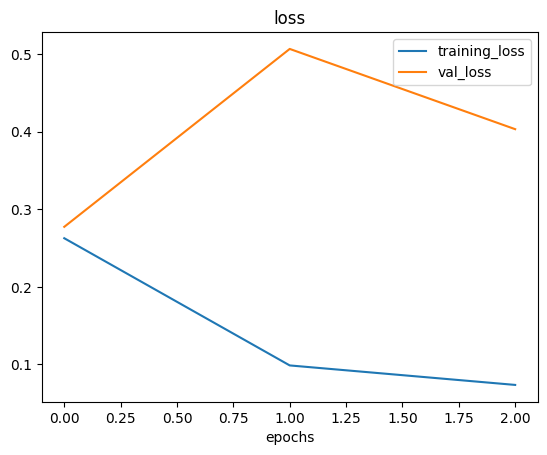

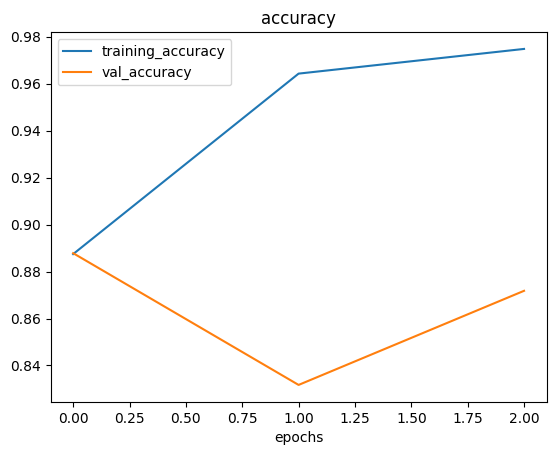

In [35]:
plot_loss_curves(history_2a)

Looks like after the first epoch, the model started to overfit.I will decrease the learning rate and see if theres a notable change.

20/20 [==============================] - 5s 254ms/step
Accuracy: 87.18% 
 Precision: 89.06% 
 Recall: 87.18% 
 F1-Score: 86.51% 



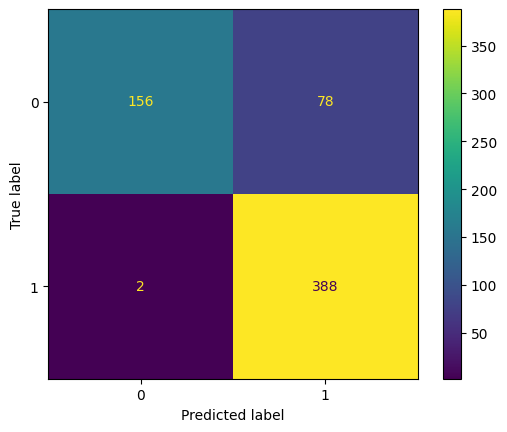

{'Accuracy': 87.17948717948718,
 'Precision': 89.06394306513826,
 'Recall': 87.17948717948718,
 'F1-Score': 86.5058172801831,
 'Confusion_matrix': array([[156,  78],
        [  2, 388]]),
 'Confusion_matrix_display': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x77fc5836fc40>}

In [36]:
deep_analysis(model = model_2a, dataset = test_data_unshuffle)

This model seems to have performed much better that the previous model with an **accuracy** of 87% and a **precision** of 89%. Since I've manage to outperform the base line which implemented **feature extraction transfer learning**, I will now try to perform **fine tuning** to beat this model as my final experiment.

I will **fine tune** the last 10 layers of the efficientnet model.

In [41]:
#The url that i will be loading the model from
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

 #Downloads the pretrained model and save it as a keras layer
feature_extraction_layer_v2 = hub.KerasLayer(efficientnet_url,
                                             trainable = False,#Freezes the patterns that the pretrained model has learned
                                             name = "Feature_Extraction_Layer",
                                             input_shape = IMAGE_SHAPE+(3,)) #Turns shape into (224, 224, 3)
    #We will be able to put the entire model as a layer into the model that we create

#The Fine Tuning Process
For the fine tuning process I first train the model, with the layers in the **efficientnet** model being untrainable. Then I will make the last ten layers of the **efficientnet** model **trainable** (I will make sure to decrease the **learning rate** by 10x its original value so that the model does not **overfit** for the remainder of the training process). I will keep track of the **initial epochs** so that can keep track of the training steps.

Since I'm integrating a **feature extraction layer** like **EfficientNet V2** (downloaded from TensorFlow Hub) into your model, the **EfficientNet V2** in this case outputs a **flattened feature vector**, which is suitable for feeding into **dense layers** but not directly into **convolutional layers** like **Conv2D**.

In [81]:
model_3a = Sequential([
   #tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer"),
    #data_augmentation_layer,
    feature_extraction_layer_v2,
    #Conv2D(filters = 10, kernel_size = (3,3), activation = "relu"),
   # MaxPool2D(pool_size = (2,2), padding = "valid"),
    #Flatten(),
   Dense(100, activation = "relu"),
    Dense(1, activation = "sigmoid", name = "output_layer")
])

model_3a.compile(loss = BinaryCrossentropy(),
                 optimizer = Adam(learning_rate = 0.001),
                 metrics = ["accuracy"])

In [82]:
history_3a = model_3a.fit(train_data, epochs = 3, steps_per_epoch = len(train_data),
                          validation_data = test_data, validation_steps = len(test_data),
             callbacks = [early_stop, lr_scheduler])

Epoch 1/3
164/164 [==============================] - 50s 293ms/step - loss: 0.1260 - accuracy: 0.9516 - val_loss: 0.1952 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 2/3
164/164 [==============================] - 48s 290ms/step - loss: 0.0710 - accuracy: 0.9731 - val_loss: 0.3062 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 3/3
164/164 [==============================] - 47s 288ms/step - loss: 0.0525 - accuracy: 0.9784 - val_loss: 0.2567 - val_accuracy: 0.9151 - lr: 0.0010
Epoch 3: early stopping


91% accuracy is good; now lets take the metrics and try to surpass it after **fine tuning**.

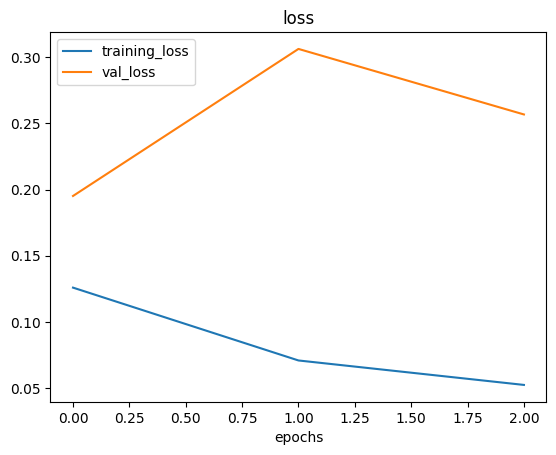

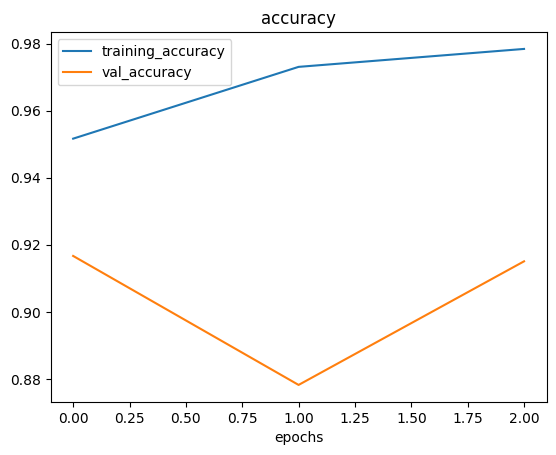

In [83]:
plot_loss_curves(history_3a)

20/20 [==============================] - 6s 262ms/step
Accuracy: 91.51% 
 Precision: 92.43% 
 Recall: 91.51% 
 F1-Score: 91.25% 



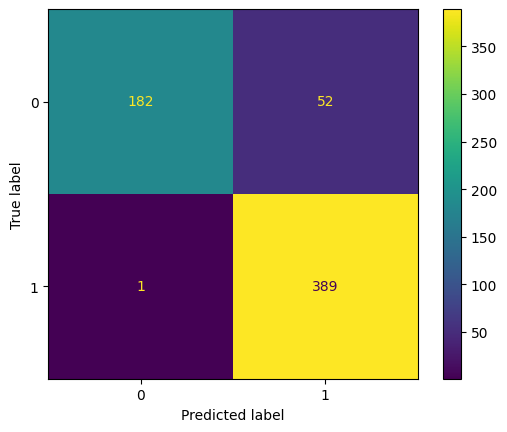

{'Accuracy': 91.50641025641025,
 'Precision': 92.42546745474147,
 'Recall': 91.50641025641025,
 'F1-Score': 91.24765169813608,
 'Confusion_matrix': array([[182,  52],
        [  1, 389]]),
 'Confusion_matrix_display': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x77fb961972e0>}

In [84]:
deep_analysis(model = model_3a, dataset = test_data_unshuffle)

1/1 [==============================] - 1s 1s/step


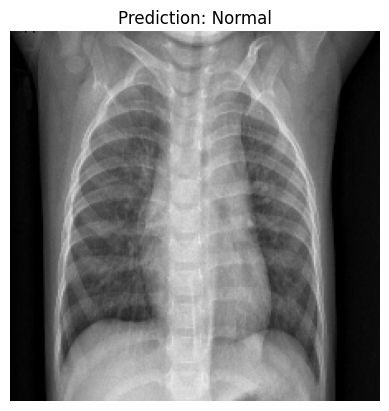

In [90]:
pred_and_plot(model = model_3a, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg", class_names = class_names)

1/1 [==============================] - 0s 31ms/step


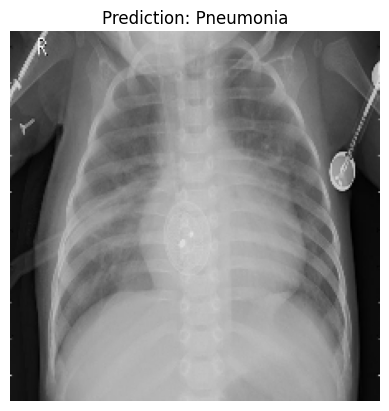

In [91]:
pred_and_plot(model = model_3a, filename = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1768914-0003.jpeg", class_names = class_names)


In [92]:
model_3a.save("Pneumonia_xray_classification_better")

In [94]:
for layer_number, layer in enumerate(model_3a.layers):
  print(layer_number, layer.name, layer.trainable)


0 Feature_Extraction_Layer False
1 dense_11 True
2 output_layer True
